# Snowpark Python: How to Migrate Your Data Science Projects

*With Python for Snowpark now in GA, we can run models using Snowflake's processing power. This tutorial will show us how.*

With **[Python for Snowpark](https://www.snowflake.com/blog/snowpark-python-feature-engineering-machine-learning/)** now in GA, we have the ability to run our models closer to where our data lives. Aided by the processing power of Snowflake, we can run our model predictions easily.

In this tutorial, we're going to take the **[California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)** dataset, which is fairly know, and upload it into Snowflake using **Snowpark for Python**. Then, we will do a quick data exploration, cross-validation, and fine-tunning to deploy our model into Snowflake. This way, we can get our predictions using Snowflake's data warehouse. 



## 1. Load Necesary Snowpark Packages and Connect to Snowflake

We will begin by importing necesary libraries, the session class will give us everything we need to connect to Snowflake, using the same parameters from the connect function in the Snowflake Connector for Python. To create a session we will build a Python dictionary containing the names and values of the parameters, see example below. 

For this example, we placed those parameters in a different file called "config.py".

Let's begin by importing the standard machine learning libraries like Pandas, Numpy and Matplotlib, as well as several Snowpark libraries such as "functions". These provide utility and SQL functions to generate column expressions to pass to DataFrame transformation methods, date types, and UDF. 

What's the purpose of this? To build our predictions in Snowflake. 



In [143]:
# Snowflake packages
import snowflake.snowpark
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.functions import udf,col, is_null

#Python packages
import sys
import cachetools
import os
import pandas as pd
import numpy as np
import io
import joblib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


#Snowflake connection info is saved in config.py
from config import snowflake_conn_prop



Print Snowpark version.

In [113]:
from snowflake.snowpark import version
print(version.VERSION)

(0, 8, 0)


Now, we'll load our data using pd.read() and pull a sample.

In [161]:
#Read the housing data

data=pd.read_csv('https://raw.githubusercontent.com/serbre/Snowpark_migrate/main/housing.csv')

data.columns= ['LONGITUDE',
 'LATITUDE',
 'HOUSING_MEDIAN_AGE',
 'TOTAL_ROOMS',
 'TOTAL_BEDROOMS',
 'POPULATION',
 'HOUSEHOLDS',
 'MEDIAN_INCOME',
 'MEDIAN_HOUSE_VALUE',
 'OCEAN_PROXIMITY']

In [9]:
data.head()

,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,MEDIAN_HOUSE_VALUE,OCEAN_PROXIMITY
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The next step is to create a connection. We'll pass the dictionary containing the name and values of the parameters from config.py to the session.builder.configs method. This will return an object with the parameters needed to call the Create method and establish connection.

In [114]:
session = Session.builder.configs(snowflake_conn_prop).create()


To create our environment in Snowflake, you can load different variables with the rolename, database, schema, and warehouse name, and run them within an SQL in Snowflake environment using the session.sql command. You can update these to adapt your Snowflake environment. Just make sure you have create privileges in your database.

Snowpark operations are lazy. To trigger queries, you need to call an Action function such as the Collect function.


In [115]:
rolename = "SYSADMIN"
dbname = "DEMO"
schemaname = "TEST"
warehouse = "COMPUTE_WH"

session.sql(f"USE ROLE {rolename}").collect()

[Row(status='Statement executed successfully.')]

In [116]:
#  Create a database, schema, warehouse)
session.sql(f"CREATE DATABASE IF NOT EXISTS {dbname}").collect()
session.sql(f"CREATE SCHEMA IF NOT EXISTS {dbname}.{schemaname}").collect()
session.sql(f"CREATE WAREHOUSE  IF NOT EXISTS {warehouse} \
                WAREHOUSE_SIZE = 'Large' \
                AUTO_SUSPEND = 300 \
                AUTO_RESUME = TRUE \
                MIN_CLUSTER_COUNT = 1 \
                MAX_CLUSTER_COUNT = 3 \
                SCALING_POLICY = 'STANDARD' ").collect()

[Row(status='COMPUTE_WH already exists, statement succeeded.')]

In [117]:
session.sql(f"USE WAREHOUSE {warehouse}").collect()
session.sql(f"USE SCHEMA {dbname}.{schemaname}").collect()

[Row(status='Statement executed successfully.')]

In [118]:
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())


[Row(CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='DEMO', CURRENT_SCHEMA()='TEST')]


In [ ]:
session.add_packages('snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools', 'xgboost')

Now, to explain the whole process, we will load our CSV into Snowflake and use it for our analysis. In your case, the data might already be in Snowflake.

The following variable names contain our file name. In the housing.csv example, we use this same name for the stage for the file, model, and UDF, as well as the raw table name.

The session.file.put command will load the file in the stage. Please note that, for this exercise, it's important to have our file in the same folder as the notebook.



In [18]:
filename = "housing.csv"
stagename = "rawdata"
model_stage = "models"
rawtable = "housing"
udf="udf"

In [20]:
# Create Snowflake stage
session.sql(f"create or replace stage {stagename} DIRECTORY = (ENABLE = TRUE);").collect()

# Put the file in the stage
session.file.put(filename,stagename)

[PutResult(source='housing.csv', target='housing.csv.gz', source_size=1423529, target_size=396000, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [21]:
session.sql(f"create or replace stage {model_stage} DIRECTORY = (ENABLE = TRUE) copy_options = (on_error='skip_file');").collect()
session.sql(f"create or replace stage {udf} copy_options = (on_error='skip_file');").collect()

[Row(status='Stage area UDF successfully created.')]

The next step is to create our schema by using a SructType containing names of the columns and data types of such columns. Then, we'll call the schema property to return an object configured to read files that contains the specified fields. 

In the Options property, we define the format fields like compressions, field delimiter, and type. Finally, with the CSV option, we indicate the location of our file to create our table.

In [22]:
schema_for_data_file = StructType([
    StructField("longitude",IntegerType()),
    StructField("latitude",IntegerType()),
    StructField("housing_median_age",IntegerType()),
    StructField("total_rooms",IntegerType()),
    StructField("total_bedrooms",IntegerType()),
    StructField("population",IntegerType()),
    StructField("households",IntegerType()),
    StructField("median_income",IntegerType()),
    StructField("median_house_value",IntegerType()),
    StructField("ocean_proximity",StringType())])


In [23]:
csv_reader=session.read.schema(schema_for_data_file)

In [24]:
format_options={"compression": "gzip",  "type" : "csv", "field_delimiter" : ",","skip_header": 1}
csv_reader=csv_reader.options(format_options)

In [38]:
df = csv_reader.csv("@rawdata/housing.csv.gz")

In [39]:
# In case you already have a table there

drop_result = session.sql(f"drop table if exists {rawtable}").collect() 
drop_result

[Row(status='HOUSING successfully dropped.')]

In [40]:
df_table=df.copy_into_table("housing",format_type_options=format_options ,force=True)

In [41]:
%%time

housing_snowflake = session.table('housing')

pd.pandas.set_option('display.max_columns', None)

data = housing_snowflake.toPandas()
data.head()

CPU times: user 429 ms, sys: 32 ms, total: 461 ms
Wall time: 3.5 s


,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,MEDIAN_HOUSE_VALUE,OCEAN_PROXIMITY
0,-122,38,41,880,129.0,322,126,8,452600,NEAR BAY
1,-122,38,21,7099,1106.0,2401,1138,8,358500,NEAR BAY
2,-122,38,52,1467,190.0,496,177,7,352100,NEAR BAY
3,-122,38,52,1274,235.0,558,219,6,341300,NEAR BAY
4,-122,38,52,1627,280.0,565,259,4,342200,NEAR BAY


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LONGITUDE           20640 non-null  int8   
 1   LATITUDE            20640 non-null  int8   
 2   HOUSING_MEDIAN_AGE  20640 non-null  int8   
 3   TOTAL_ROOMS         20640 non-null  int32  
 4   TOTAL_BEDROOMS      20433 non-null  float64
 5   POPULATION          20640 non-null  int32  
 6   HOUSEHOLDS          20640 non-null  int16  
 7   MEDIAN_INCOME       20640 non-null  int8   
 8   MEDIAN_HOUSE_VALUE  20640 non-null  int32  
 9   OCEAN_PROXIMITY     20640 non-null  object 
dtypes: float64(1), int16(1), int32(3), int8(4), object(1)
memory usage: 685.4+ KB


## 2. Perform Exploratory Data Analysis (EDA)

Now that we have our data in Snowflake, we can decide if we want to work with Snowpark Python or with our preferred Python native libraries. Snowpark offers the ability to run most of the analysis in Snowflake, preventing data from leaving your database.

We'll perform a quick visual EDA starting with a histogram on numeric variables to see how our data is represented.

At first glance, we observe that the attributes have very different ranges. Using such insight, we'll work on feature scaling with transformation pipelines.

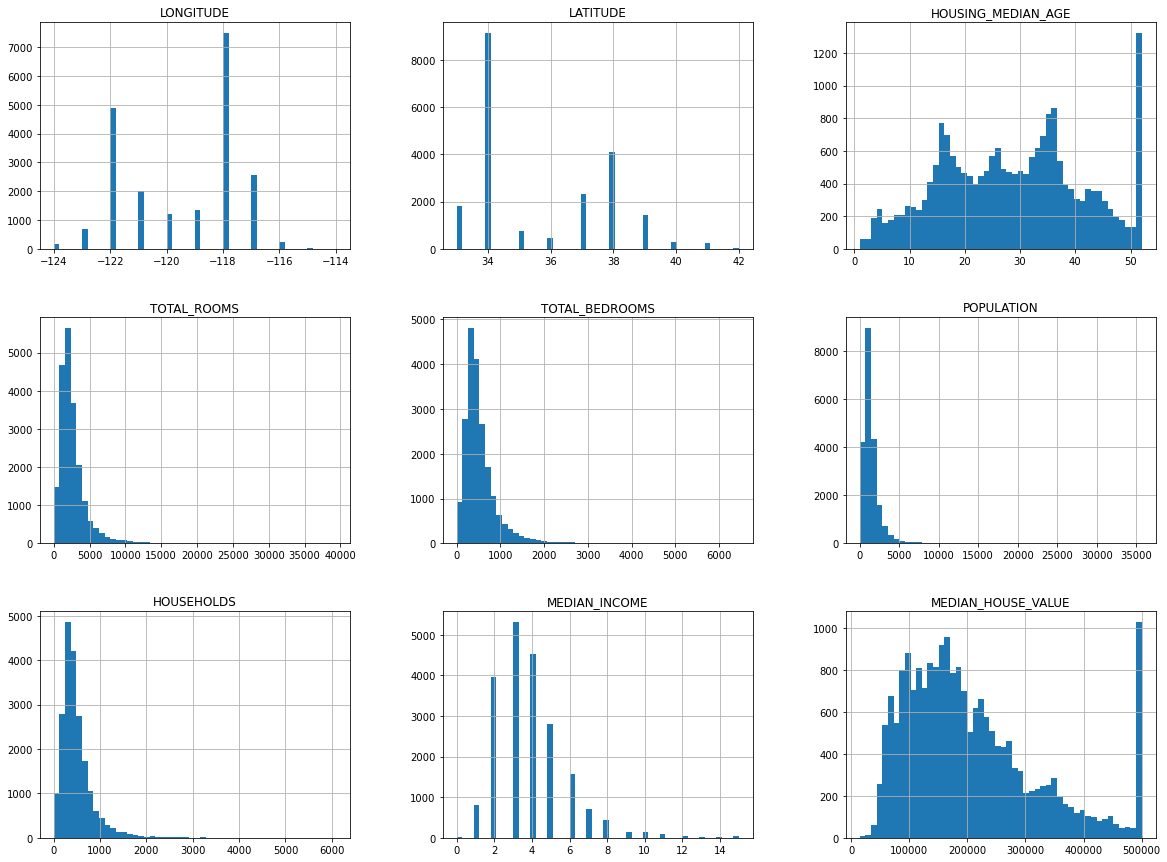

In [30]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [31]:
cat_vars = [var for var in data.columns if ((data[var].dtype == 'O') or (data[var].dtype=="bool"))]
print('Categorical Variables:' , cat_vars)

num_vars = [var for var in data.columns if var not in cat_vars]
print('Numerical Variables:', num_vars)


Categorical Variables: ['OCEAN_PROXIMITY']
Numerical Variables: ['LONGITUDE', 'LATITUDE', 'HOUSING_MEDIAN_AGE', 'TOTAL_ROOMS', 'TOTAL_BEDROOMS', 'POPULATION', 'HOUSEHOLDS', 'MEDIAN_INCOME', 'MEDIAN_HOUSE_VALUE']



Because median income is an important predictor for median housing prices, we'll create a new attribute with pd.cut() called INCOME_CAT. This will define 5 categories (labeled from 1 to 5) based on Median_INCOME cuts. 

In [99]:
data["INCOME_CAT"] = pd.cut(data["MEDIAN_INCOME"],
 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
 labels=[1, 2, 3, 4, 5])

At this point, we need to clean our data and since null values can bring problems, below we can see TOTAL_BEDROOMS and INCOME_CAT having lower non-null count than the rest of the dataset, let's turn our pandas dataset back to Snowpark dataframe and handle those null values.

In [134]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   LONGITUDE           20640 non-null  int8    
 1   LATITUDE            20640 non-null  int8    
 2   HOUSING_MEDIAN_AGE  20640 non-null  int8    
 3   TOTAL_ROOMS         20640 non-null  int32   
 4   TOTAL_BEDROOMS      20433 non-null  float64 
 5   POPULATION          20640 non-null  int32   
 6   HOUSEHOLDS          20640 non-null  int16   
 7   MEDIAN_INCOME       20640 non-null  int8    
 8   MEDIAN_HOUSE_VALUE  20640 non-null  int32   
 9   OCEAN_PROXIMITY     20640 non-null  object  
 10  INCOME_CAT          20628 non-null  category
dtypes: category(1), float64(1), int16(1), int32(3), int8(4), object(1)
memory usage: 705.8+ KB


In [127]:
data_no_nulls=session.create_dataframe(data)

Variables TOTAL_BEDROOMS and INCOME_CAT have 207 and 12 null values respectively.

In [128]:
bedrooms_null=data_no_nulls.filter(is_null(col('TOTAL_BEDROOMS'))).count()
income_cat_null=data_no_nulls.filter(is_null(col('INCOME_CAT'))).count()

print(f"Total Bedrooms nulls: {bedrooms_null} \nIncome cat nulls: {income_cat_null}")

Total Bedrooms nulls: 207 
Income cat nulls: 12


In this case, we're going to drop the NAs, but calculating the mean instead is also an option if the dataset is small and you need each and every row.

In [129]:
data_no_nulls=data_no_nulls.na.drop()

In [136]:
data_no_nulls.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20421 entries, 0 to 20420
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LONGITUDE           20421 non-null  int8   
 1   LATITUDE            20421 non-null  int8   
 2   HOUSING_MEDIAN_AGE  20421 non-null  int8   
 3   TOTAL_ROOMS         20421 non-null  int32  
 4   TOTAL_BEDROOMS      20421 non-null  float64
 5   POPULATION          20421 non-null  int32  
 6   HOUSEHOLDS          20421 non-null  int16  
 7   MEDIAN_INCOME       20421 non-null  int8   
 8   MEDIAN_HOUSE_VALUE  20421 non-null  int32  
 9   OCEAN_PROXIMITY     20421 non-null  object 
 10  INCOME_CAT          20421 non-null  int8   
dtypes: float64(1), int16(1), int32(3), int8(5), object(1)
memory usage: 698.1+ KB


Now, we can load it to snowflake without any null values.

In [132]:
data_no_nulls.write.mode("overwrite").save_as_table("Data_no_nulls")

## 3. Training

We're getting into the fun part! We can test different Machine Learning algoritms and see how they perform in our data. To do so, we'll create a Python funtion that encapsulates everything we consider necessary to train our model in Snowflake. 

The function save_file will drop our model into Snowflake to create a .joblib file. We can then call it and use it for inference after our training. 


In [147]:
def save_file(session, model, path):
  input_stream = io.BytesIO()
  joblib.dump(model, input_stream)
  session._conn._cursor.upload_stream(input_stream, path)
  return "successfully created file: " + path


The train_model function, as the name indicates, trains our model into Snowflake using the parameters we choose. 

The function is divided into five parts:

#### 1. Ingestion

First, let's create a selection to pick the models we want to test, in this case we're going to include XGBoost and Random forest
We'll take our data, cleaned from null values, and put it as a Pandas dataframe. 

#### 2. Split the Train and Test Set

Perform a stratified split of our data based on INCOME_CAT. Thus, we can be sure that our test set has almost the same proportion of income categories than the full dataset. For more information on why is this important, please check out pages 57 and 58 of the second reference we included at the end of this tutotial. Finally, we'll save the train and test set and get the data labels.

#### 3.  Create a Pipeline for Numerical and Categorical Features 

This is where the transformation process takes place. By separating our numerical and categorical features to prepare them for training, we're performing feature scaling to get all variables in the same scale. We can then apply one hot encoder to convert categories into numbers, fit them in the pre-processing pipeline. 


#### 4. Predict on the Test Set and Return the Root Mean Squared Error (RMSE)

In this step we use cross-validation and  RandomizedSearchCV to find optimal parameters for our algorithm, the final step saves the model in the MODEL stage as .joblib file. The full_pipeline.transform will apply transformations done in the training set. In this case, we used the Random Forest Regressor.


In [149]:

def train_model(session: snowflake.snowpark.Session, table:str, params_distr:dict, algorithm:str) -> float:
        #1. Ingestion
        #Let's create a selection to pick the models we want to test, in this case we're going to include XGBoost and Random forest
        models_select= {}
        xgb= XGBRegressor(nthreads=1, random_state=42)
        forest= RandomForestRegressor(random_state=42)   
        models_select["xgb"] = xgb
        models_select["forest"] = forest
        
        #Load the table without null values 
        data_no_nulls = session.table(table)
        data=data_no_nulls.to_pandas()
        
        #2. split the train and test set
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(data, data["INCOME_CAT"]):
            strat_train_set = data.iloc[train_index]
            strat_test_set = data.iloc[test_index]
        #strat_train_set, strat_test_set = data.random_split([0.8, 0.2], seed=82)

        # save the train and test sets as time stamped tables in Snowflake 
        session.create_dataframe(strat_train_set).write.mode("overwrite").save_as_table("HOUSING_TRAIN")
        session.create_dataframe(strat_test_set).write.mode("overwrite").save_as_table("HOUSING_TEST")

        #3. create a pipeline for numerical and categorical features    
        data = strat_train_set.drop(['MEDIAN_HOUSE_VALUE', 'INCOME_CAT'], axis=1)
        data_labels = strat_train_set["MEDIAN_HOUSE_VALUE"].copy()
        housing_test = strat_test_set.drop("MEDIAN_HOUSE_VALUE", axis=1)
        housing_test_labels = strat_test_set["MEDIAN_HOUSE_VALUE"].copy()

        
        # numerical features
        housing_num = data.drop("OCEAN_PROXIMITY", axis=1)
        # create a pipeline for numerical features
        num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ])
        data_num_tr = num_pipeline.fit_transform(housing_num)

        num_attribs = list(housing_num)
        cat_attribs = ["OCEAN_PROXIMITY"]
        
        preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ])
        #data_prepared = preprocessor.fit_transform(data)
        full_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', models_select[algorithm]),
            ])  
        
        #4 predict on the test set and return the root mean squared error (RMSE)
        
        # Good practice of repeated k-fold cross-validation with 3 repeats and 10 folds in this case we select 5 for faster execution.
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
        random_search = RandomizedSearchCV(full_pipeline, param_distributions=params_distr,
                                    n_iter=50, cv=cv, scoring='neg_mean_squared_error',
                                    verbose=1, random_state=42)

        random_search.fit(data, data_labels)
         #5 save the model
        save_file(session, random_search, "@MODELS/housing_reg.joblib") 
        negative_mse = random_search.best_score_
        rmse = np.sqrt(-negative_mse)
        return rmse

In [150]:
params_distr = {'model__n_estimators': [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
    'model__min_samples_split': [2, 6, 10],
    'model__min_samples_leaf':[1, 3, 4],
    'model__bootstrap': [True, False]}

table="Data_no_nulls"



In [151]:
# Create an instance of StoredProcedure using the sproc() function
train_model_sp = sproc(train_model, replace=True, session=session)


In [152]:
train_model_sp(table,params_distr, "forest", session=session)

59098.024468258394

Random Forest gets us a prediction error of $59098. Although this isn't a satisfactory result, we're going to leave it there.  When working with any data set, please check different algorithms and features to see which one will give you best results. The function built previously can be expanded to include other algorithms besides Random Forests. 

<mark>Note:</mark> By the time this article was written, executing XGBoost would eventually exhaust warehouse memory, but with the recent release of Snowpark in GA, Snowflake also announced [Snowpark-Optimized Warehouses](https://docs.snowflake.com/en/user-guide/warehouses-snowpark-optimized.html), this are recommended for workloads that have large memory requirements such as ML training.

You will see XGBoost already there, so just give a try and also add your own.

## 4. Deploy the Model in Snowflake

Let's say our model is trained and tuned and we're satisifed with the accuracy. In this case, let's proceed to deploy it to Snowflake using Python UDFs.



The Snowpark library uploads and executes UDFs on the server. If your UDF has a dependency or needs to read data from a file, you need to call Session.add_import(). For this case, we added the models from the model stage. The next step is to create a function that will reconstruct a Python object from a file persisted with joblib.dump, like we did on the save_file function.

In [153]:

import sys
import cachetools
import os
session.add_import("@MODELS/housing_reg.joblib") 

@cachetools.cached(cache={})
def read_file(filename):
       import_dir = sys._xoptions.get("snowflake_import_directory")
       if import_dir:
              with open(os.path.join(import_dir, filename), 'rb') as file:
                     m = joblib.load(file)
                     return m


The **@udf** decorator will package the function as Snowflake Python UDF and save the model into Snowflake's internal stage UDF. The function name will be "predict". It will run the previous read_file function, load it into the variable called "m", create a dataframe with locals variables, and run "predict" on the variable row. 

In [155]:
from snowflake.snowpark.functions import udf

features = ['LONGITUDE', 'LATITUDE', 'HOUSING_MEDIAN_AGE', 'TOTAL_ROOMS',
       'TOTAL_BEDROOMS', 'POPULATION', 'HOUSEHOLDS', 'MEDIAN_INCOME', 'OCEAN_PROXIMITY']

@udf(name='predict', is_permanent=True, stage_location='@udf', replace=True, session=session)
def predict(LONGITUDE: float, LATITUDE: float, HOUSING_MEDIAN_AGE: float, TOTAL_ROOMS: float, 
                    TOTAL_BEDROOMS: float, POPULATION: float, HOUSEHOLDS: float, MEDIAN_INCOME: float, 
                    OCEAN_PROXIMITY: str) -> float:
       m = read_file('housing_reg.joblib')       
       row = pd.DataFrame([locals()], columns=features)
       return m.predict(row)[0]

We load the Housing_Test set we created before in snowdf_test. If we want to predict "Median_house_Value", we drop that one and the one we created earlier "Income_Cat". Once that is done, we call our predict UDF.

In [156]:

from snowflake.snowpark import functions as F

snowdf_test = session.table("HOUSING_TEST")
inputs = snowdf_test.drop("MEDIAN_HOUSE_VALUE", "INCOME_CAT")
snowdf_results = snowdf_test.select(
                    *inputs,
                    predict(*inputs).alias('PREDICTION'), 
                    (F.col('MEDIAN_HOUSE_VALUE')).alias('ACTUAL_LABEL')
                    ).limit(20)
                    


In [157]:
snowdf_results.to_pandas()

,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,OCEAN_PROXIMITY,PREDICTION,ACTUAL_LABEL
0,-118,34,48,1226,288.0,370,264,4,<1H OCEAN,337086.605000,450000
1,-117,33,7,10665,2576.0,4917,2424,2,<1H OCEAN,143332.138278,159500
2,-122,38,52,3563,832.0,1712,787,3,NEAR BAY,274763.820107,335700
3,-118,34,15,4713,671.0,2197,673,8,<1H OCEAN,360629.228535,294800
4,-122,39,41,1317,309.0,856,337,2,INLAND,88481.666667,64100
5,-119,34,27,1527,220.0,756,226,6,<1H OCEAN,291188.946429,227000
6,-118,34,38,1437,272.0,590,250,5,<1H OCEAN,341047.958493,358000
7,-118,34,20,9893,2283.0,7228,2159,3,<1H OCEAN,188565.617965,186700
8,-122,38,52,1900,290.0,665,276,5,NEAR OCEAN,335901.317419,500001
9,-119,34,29,1287,194.0,525,187,6,<1H OCEAN,324530.925852,319300


And finally, we place the Actual label vs the prediction:

In [158]:
snowdf_results.select(snowdf_results.PREDICTION,snowdf_results.ACTUAL_LABEL).to_pandas()

,PREDICTION,ACTUAL_LABEL
0,337086.605000,450000
1,143332.138278,159500
2,274763.820107,335700
3,360629.228535,294800
4,88481.666667,64100
5,291188.946429,227000
6,341047.958493,358000
7,188565.617965,186700
8,335901.317419,500001
9,324530.925852,319300


And this is the view we get placing a Housing_Detection table with our predictions in Snowflake.

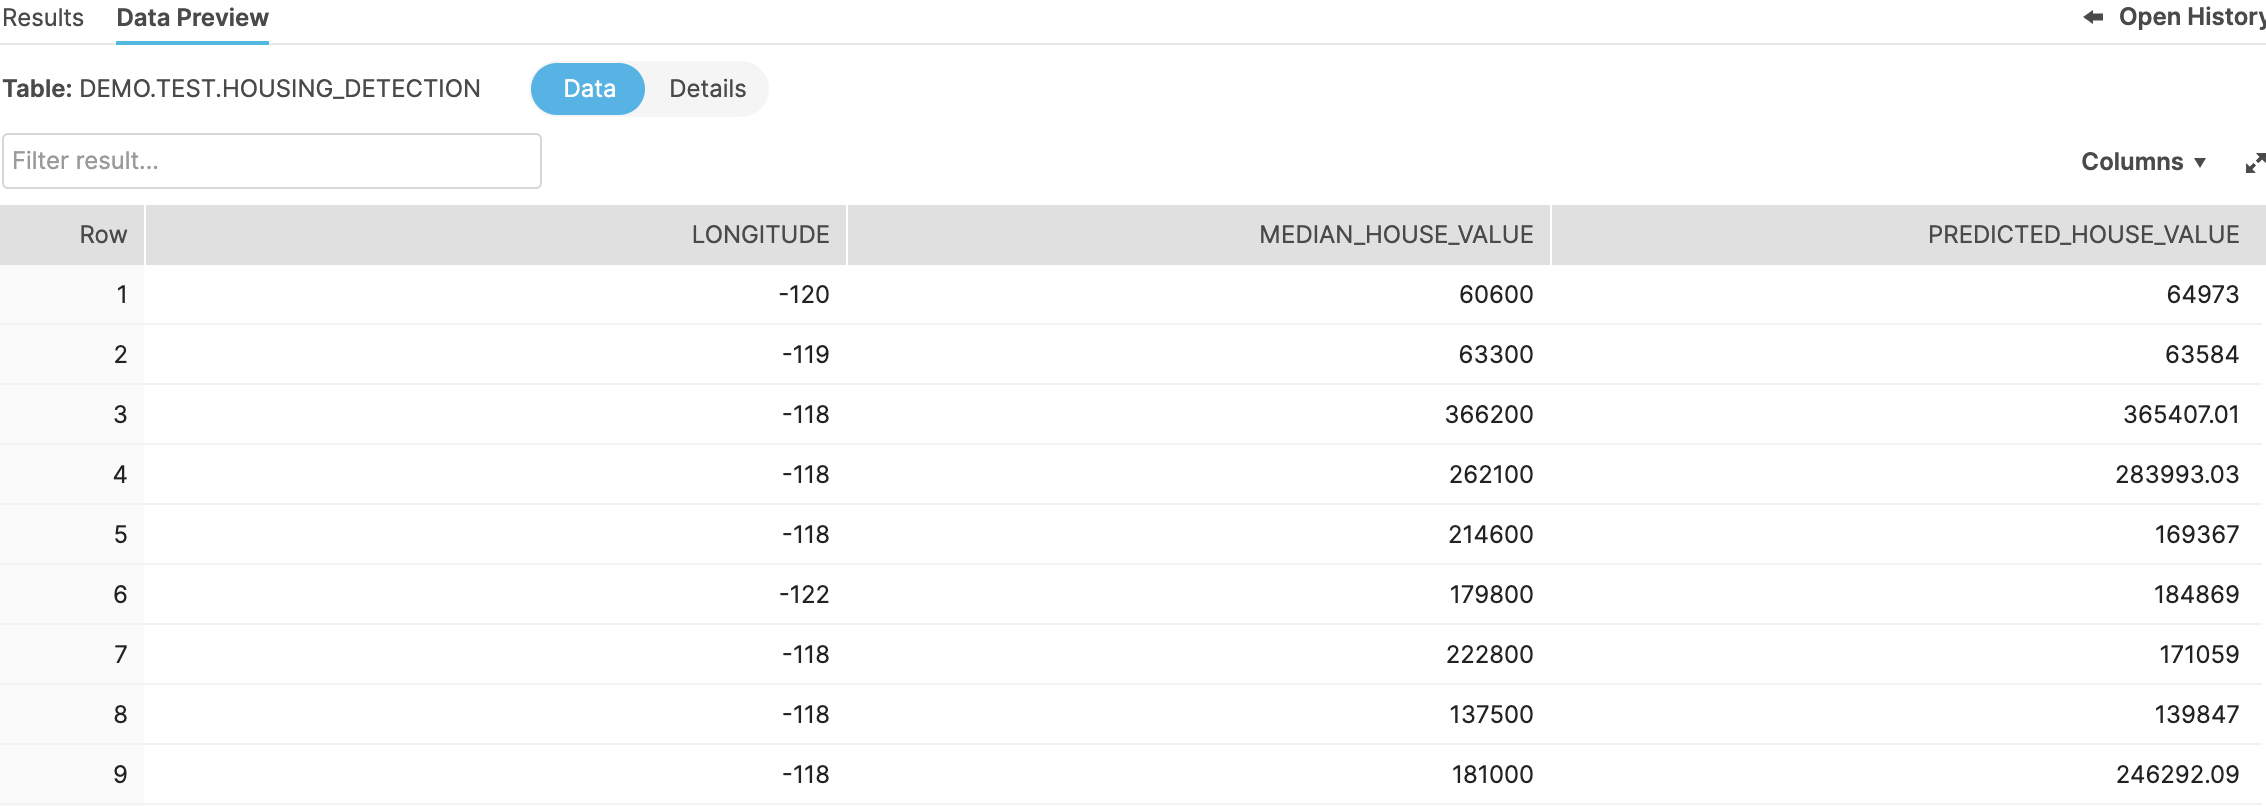

# Too Long, Didn't Read:

In this article/tutorial, you learned how to take an already available data science model and migrate it to Snowflake using Snowpark for Python.

Some of the points covered here were:
- How to connect to Snowflake
- Loading data using Snowpark functions like copy_into
- Connect to your data in Snowflake
- Perform data science predictive modeling in our data with EDA, data cleaning, Cross-validation and fine tunnning 
- Deploy the model in Snowflake with UDF python functions.

I hope you enjoyed the tutorial as much as we did creating it! As a closing thought, if you no longer need to use a session for executing queries and want to cancel any queries that are currently running, calling the Close method from the Session object is a good way to go.

In [ ]:
session.close()

# More information and references 


1. Snowpark Developer Guide for Python https://docs.snowflake.com/en/developer-guide/snowpark/python/index.html

2. Snowpark-optimized Warehouses https://docs.snowflake.com/en/user-guide/warehouses-snowpark-optimized.html#billing-for-snowpark-optimized-warehouses

3. Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron (O’Reilly).Copyright 2019 Aurélien Géron, 978-1-492-03264-9.





